In [1]:
import glob
import os
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from utils import print_full
from scipy.ndimage import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
from utils import *
from visualize import *
set_plot_params()
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


from model_neuroformer import GPT, GPTConfig, neuralGPTConfig, Decoder
from trainer import Trainer, TrainerConfig


import json
# for i in {1..10}; do python3 -m gather_atts.py; done




In [2]:
base_path = "data/LargeRandNet/"
stim_path = "data/LargeRandNet/LargeRandNet_cosinput.csv"
response_path = "data/LargeRandNet/LargeRandNet_SpikeTime.csv"

if not os.path.exists(response_path):
    print("Downloading data...")
    import gdown
    url = "https://drive.google.com/drive/folders/1vxHg7FaFQDjQZUNMgvo5wAOlFIcZ2uv-?usp=share_link"
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output="data/LargeRandNet/")


# Load Data
stimulus = np.loadtxt(stim_path, delimiter=',')
df = pd.read_csv(response_path, names=['Time', 'ID'])
df['Time'] = df['Time'].round(4)
df['Trial'] = df['Time'].apply(lambda x: x // 100 + 1).astype(int)
df['Time'] = df['Time'].apply(lambda x: x - ((x // 100) * 100)).round(2)




In [3]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)




In [4]:
from utils import set_seed
n_seed = 25
set_seed(n_seed)




In [5]:
stimulus.shape



(1000, 1000)

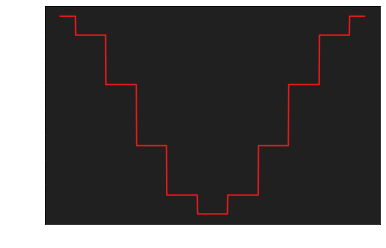

In [6]:
plt.plot(stimulus[0, :])



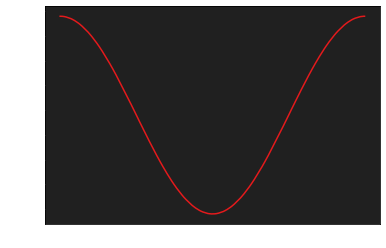

In [7]:
plt.plot(stimulus[:, 0])



In [8]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
frame_window = 20
window = 0.5
window_prev = 20 - window
dt = 0.1
dt_frames = 1/10
p_window = window / (window + window_prev)
# intervals = np.load(os.path.join(base_path, "intervals.npy"))
intervals = None


from SpikeVidUtils import make_intervals

df['real_interval'] = make_intervals(df, dt)
df['Interval'] = make_intervals(df, window)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)]


In [9]:
df


,Time,ID,Trial,real_interval,Interval,Interval_2
0,2.2,855.0,1,2.2,2.5,19.5
1,3.1,959.0,1,3.1,3.5,19.5
2,3.2,922.0,1,3.2,3.5,19.5
3,3.5,972.0,1,3.5,3.5,19.5
4,3.7,142.0,1,3.7,4.0,19.5
...,...,...,...,...,...,...
882780,98.6,19.0,500,98.6,99.0,117.0
882781,98.7,94.0,500,98.7,99.0,117.0
882782,98.8,52.0,500,98.8,99.0,117.0
882783,98.9,78.0,500,98.9,99.0,117.0


In [10]:
int_trials = df.groupby(['Interval', 'Trial']).size()
print(int_trials.mean())
# df.groupby(['Interval', 'Trial']).agg(['nunique'])model_path
# var_group = 'Interval_2'
# n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
# df.groupby(['Interval_2', 'Trial']).size().mean()





9.68422611538335


In [11]:
from SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_embd = 256
frame_feats = torch.tensor(stimulus, dtype=torch.float32).transpose(1, 0)
frame_block_size = 200  # math.ceil(frame_feats.shape[-1] * frame_window)
n_embd_frames = 1000

prev_id_block_size = 800    # math.ceil(frame_block_size * (1 - p_window))
id_block_size = 150           # math.ceil(frame_block_size * p_window)
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }


# translate neural embeddings to separate them from ID embeddings
neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))


19.5

In [12]:
r_split = 0.8
train_trials = sorted(df['Trial'].unique())[:int(len(df['Trial'].unique()) * r_split)]
train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]



In [13]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)


train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window, start_interval=20,
                                  dt_frames=dt_frames, intervals=intervals)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                 window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                 pred=False, window_prev=window_prev, frame_window=frame_window, start_interval=20,
                                 dt_frames=dt_frames, intervals=intervals)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')





Length: 705418 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150
Length: 177367 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150
train: 58888, test: 14725


In [14]:
# from utils import get_class_weights
# class_weights = get_class_weights(train_dataset, stoi, stoi_dt)




In [15]:
from model_neuroformer_LRN import GPT, GPTConfig
# initialize config class and model (holds hyperparameters)
# for is_conv in [True, False]:    
conv_layer = False
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        sparse_mask=False, p_sparse=0.25, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=6, n_state_history_layers=4, n_stimulus_layers=4, self_att_layers=8,
                        n_layer=10, n_head=8, n_embd=n_embd, 
                        contrastive=True, clip_emb=1024, clip_temp=0.5,
                        temp_emb=True, pos_emb=False,
                        id_drop=0.35, im_drop=0.35,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames)  # 0.35
model = GPT(mconf)


51200


02/10/2023 15:02:40 - INFO - model_neuroformer_LRN -   number of parameters: 1.122146e+08


In [16]:
layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)
max_epochs = 500
batch_size = round((32 * 7))
shuffle = True

## first run
# model_path = f"../models/tensorboard/LRN/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_sparse{mconf.sparse_mask}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(n_dt)}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"
# model_path = "/local/home/antonis/neuroformer/models/tensorboard/LRN/w:10_wp:10/6_Cont:True_window:10_f_window:20_df:0.1_blocksize:30_sparseFalse_conv_True_shuffle:True_batch:128_sparse_(200_200)_blocksz1060_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_10.0_max0.1_(6, 4, 10)_2_200.pt"
## weighted
weighted = True if mconf.class_weights is not None else False
title =  f'window:{window}_prev:{window_prev}'
model_path = f"""./models/tensorboard/LRN/fourrier_frames/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(n_dt)}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""
# model_path = "./models/tensorboard/LRN/weighted_False/0.5_window_CORRECTCONTRASTIVE_smoothinterval/sparse_f:None_id:None/w:0.5_wp:19.5/6_Cont:True_window:0.5_f_window:20_df:0.1_blocksize:200_conv_False_shuffle:True_batch:192_sparse_(None_None)_blocksz2000_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_19.5_max0.1_(6, 4, 4)_8_200.pt"

tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=True, patience=3, warmup_tokens=8e7, 
                    decay_weights=True, weight_decay=0.2, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=False, save_epoch=False, save_every=500)
# f"/home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:{shuffle}_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.pt")


trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
# trainer.train()



In [17]:
loader = DataLoader(train_dataset, batch_size=32 * 8, shuffle=shuffle, num_workers=4, pin_memory=True)
iterable = iter(loader)


In [18]:
x, y = next(iterable)


In [19]:
"""

RUN SIMULATION

"""

from utils import *
from IPython.utils import io
# top_p=0.25, top_p_t=0.9, temp=2.

model.load_state_dict(torch.load(model_path))
# trials = np.random.choice(train_data['Trial'].unique(), size=12)
trials = test_data['Trial'].unique()[:4]
results_dict = dict()

df_pred = None
df_true = None
n_p = 0.3   # (n + 1) * 0.05
temp = 2
# stoi['SOS'] = 2000


Trial: 401
Length: 705418 Neurons: 1003 Pixels: 0.
id block size: 150
frames: 200, id: 150


  0%|          | 0/58888 [00:00<?, ?it/s]

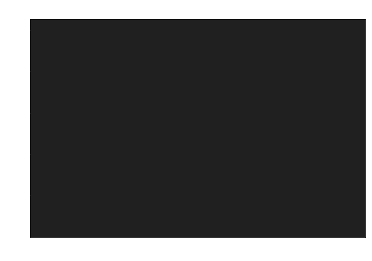

len pred: 1, len true: 2:   0%|          | 1/58888 [00:15<254:00:57, 15.53s/it]

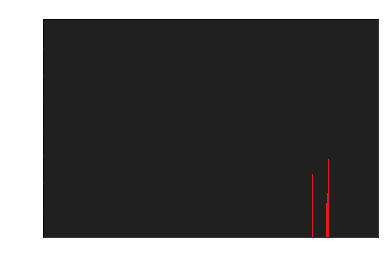

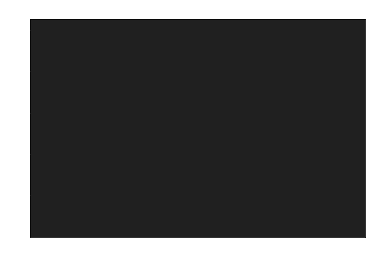

len pred: 2, len true: 4:   0%|          | 2/58888 [00:22<169:43:36, 10.38s/it]

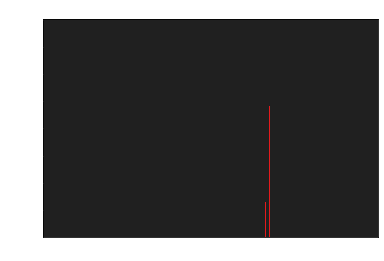

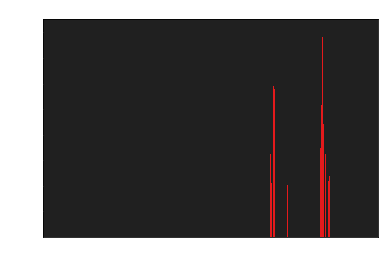

len pred: 2, len true: 4:   0%|          | 2/58888 [02:45<1351:35:51, 82.63s/it]


KeyboardInterrupt: 

In [20]:
from utils import predict_raster_recursive_time_auto

for trial in trials:    # test_data['Trial'].unique():
    # with io.capture_output() as captured:
        print(f"Trial: {trial}")
        df_trial = df[df['Trial'] == trial]
        trial_dataset = SpikeTimeVidData2(train_data,  None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                  pred=False, window_prev=window_prev, frame_window=frame_window, start_interval=20,
                                  dt_frames=dt_frames)
        trial_loader = DataLoader(trial_dataset, shuffle=False, pin_memory=False)
        results_trial = predict_raster_recursive_time_auto(model, trial_loader, window, window_prev, stoi, itos_dt, itos=itos, 
                                                           sample=True, top_p=0.75, top_p_t=0.75, temp=1.2, temp_t=1.2, frame_end=0, get_dt=True, gpu=False, pred_dt=True)
        # results_trial = predict_raster_hungarian(model, loader, itos_dt, top_p=0.75, temp=1)
        # print(f"MAX ID ---- {sorted(results_trial['ID'].unique()[-10])}")
        df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
        print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])

# df_preds[n] = df_pred
# print(f"--- n: {n}, n_p: {n_p}, temp: {temp} ---")
scores = compute_scores(df[df['Trial'].isin(trials)], df_pred)
print(scores)
print(f"pred: {len(df_pred)}, true: {len(df_true)}" )
# results_dict[n] = (scores)

In [ ]:
df_3 = df[df['Trial'].isin(trials + 2)]
df_1 = df[df['Trial'].isin(trials)]
df_2 = df[df['Trial'].isin(trials + 1)]


In [ ]:
df_pred_full = df_pred
df_list = [df_pred_full, df_1, df_2, df_3]

window_pred = 5
for df_ in df_list:
    df_['Interval'] = make_intervals(df_, window_pred)
    df_ = df_[df_['Interval'] > train_dataset.window_prev]
    df_ = df_[df_['Interval'] < window]

window_pred = window if window_pred is None else window_pred
intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))


# labels = sorted(set(df_pred_full['Interval'].unique()))
rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)

top_corr_pred = calc_corr_psth(rates_pred, rates_1)
top_corr_real = calc_corr_psth(rates_1, rates_2)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3)


In [ ]:

"""

Evaluate results

"""

from visualize import *

# df_2['Trial'] -= 2
id_pred, id_true_1, id_true_2 = len(df_pred_full['ID'].unique()), len(df_1['ID'].unique()), len(df_2['ID'].unique())
print(f"id_pred: {id_pred}, id_true_1: {id_true_1}, id_true_2: {id_true_2}")

len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_2)

scores = compute_scores(df_1, df_2)
pred_scores = compute_scores(df_1, df_pred_full)
print(f"real: {scores}")
print(f"pred: {pred_scores}")

set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) bin {window_pred}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
plt.hist(top_corr_real, label='real - real2', alpha=0.6)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6)
plt.legend(fontsize=20)
plt.show()

dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)
print(f"title: {title}")
title = title.replace('.', '_')
# count how many svg and csv files are in the directory
n_svg = len([name for name in os.listdir(dir_name) if name.endswith('.svg')])
n_csv = len([name for name in os.listdir(dir_name) if name.endswith('.csv')])
plt.savefig(os.path.join(dir_name, F'psth_corr_{title}_{n_svg}.svg'))
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{title}_{n_csv}.csv'))

plot_distribution(df_1, df_pred, save_path=os.path.join(dir_name, F'psth_dist_{title}.svg'))

total_scores = dict()
total_scores['real'] = scores
total_scores['pred'] = pred_scores


In [ ]:
len(df_pred_full['ID'].unique())
len(df_1['ID'].unique())

len(df_pred_full['Trial'].unique())
len(df_1['Trial'].unique())

In [21]:
loader = DataLoader(train_dataset, batch_size=1, shuffle=shuffle, num_workers=4, pin_memory=True)
iterable = iter(loader)
model.cpu()
model.eval()

GPT(
  (tok_emb): Embedding(1003, 256)
  (temp_emb): TemporalEmbedding(
    (dropout): Dropout(p=0.35, inplace=False)
  )
  (temp_emb_prev): TemporalEmbedding(
    (dropout): Dropout(p=0.35, inplace=False)
  )
  (id_drop): Dropout(p=0.35, inplace=False)
  (im_drop): Dropout(p=0.35, inplace=False)
  (drop): Dropout(p=0.2, inplace=False)
  (mlp_frames): ProjectNorm(
    (ln): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=1000, out_features=2000, bias=False)
      (1): GELU(approximate='none')
      (2): Linear(in_features=2000, out_features=256, bias=False)
    )
  )
  (frame_emb): PositionalEmbedding(
    (dropout): Dropout(p=0.35, inplace=False)
  )
  (clip): CLIP(
    (frame_proj): Linear(in_features=51200, out_features=1024, bias=False)
    (id_proj): Linear(in_features=38400, out_features=1024, bias=False)
  )
  (neural_visual_transformer): MultimodalTransformer(
    (neural_state_blocks): ModuleList(
      (0): Block(
  

In [24]:
# set plot grid to true
from visualize import set_plot_white
set_plot_white()

# set primary color to green
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelsize'] = 15
# plt_path = "./neuroformer/plots/debugging/masking"
# plt_path = "./neuroformer/plots/debugging/masking/frames_0"
plt_path = "./plots/frames_0:3change"
if not os.path.exists(plt_path):
    os.makedirs(plt_path)

def get_pred_dist(logits, n_step, topk):
    probs = F.softmax(logits['id'], dim=-1).cpu().numpy()[0][n_step]
    probs_n = np.array(probs)
    xaxis = np.arange(len(probs_n))
    topk=5
    topk_indices = np.argpartition(probs_n, -topk)[-topk:]
    topk_probs = probs_n[topk_indices]
    return probs_n, topk_indices, topk_probs

change = 'ids'
n_step = 3
counter = 0
replace_id = 500
while counter < 10:
    x, y = next(iterable)
    P = x['pad'].flatten()
    T = x['id'].shape[1]

    if T-P > n_step:
        counter += 1
        print(f"x['id'] = {x['id'][:, :T-P]}")
        

        plt.figure(figsize=(10, 5))
        nrows = 1
        ncols = 3

        model.eval()
        with torch.no_grad():
            logits, features, loss = model(x, y)
        
        real_probs, real_topk_indices, real_topk_probs = get_pred_dist(logits, n_step, topk=5)

        if change == 'ids':
            x['id'][:, n_step + 1:-1] = replace_id
        elif change == 'frames':
            x['frames'][:, 0:4] = torch.tensor(frame_feats[:, 0:4].unsqueeze(0))
        
        with torch.no_grad():
            logits, features, loss = model(x, y)
        eos_1_probs, eos_1_topk_indices, eos_1_topk_probs = get_pred_dist(logits, n_step, topk=5)

        # if change_ids:
        # # x['id'][:, 0:-1] = replace_id
        # with torch.no_grad():
        #     logits, features, loss = model(x, y)
        # eos_2_probs, eos_2_topk_indices, eos_2_topk_probs = get_pred_dist(logits, n_step, topk=5)

        plt.subplot(nrows, ncols, 1)
        plt.scatter(np.arange(len(real_probs)), real_probs, c='r')
        plt.title(f"real_probs: {real_probs}")
        plt.xlabel(f"ID class")
        plt.ylabel(f"Probability (p)")

        plt.subplot(nrows, ncols, 2)
        plt.scatter(np.arange(len(eos_1_probs)), eos_1_probs, c='green')
        # plt.title(f"debug_probs (only masked positions change)")
        plt.title(f"frames change")
        plt.xlabel(f"ID class")

        # plt.subplot(nrows, ncols, 3)
        # plt.scatter(np.arange(len(eos_2_probs)), eos_2_probs, c='r')
        # plt.title(f"testing_probs (all positions change)")
        # plt.xlabel(f"ID class")

        # real1_isequal = np.array_equal(real_probs, eos_1_probs)
        # real2_isequal = np.array_equal(real_topk_indices, eos_2_probs)

        # print(f"real1_isequal: {real1_isequal}, real2_isequal: {real2_isequal}")

        plt.savefig(os.path.join(plt_path, F'prob_dist_{title}_{counter}_buggy_frame.png'))


# print(f"ix: {ix}, x_true: {y['id'][0, i]} ")

x['id'] = tensor([[1000,  449,  158,  281]])


In [ ]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)


train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window, start_interval=20,
                                  dt_frames=dt_frames, intervals=intervals)

In [ ]:
iterable = iter(train_dataset)

In [ ]:
x, y = next(iterable)

T = len(x['id'])
P = x['pad'] - 1
T_prev = len(x['id_prev'])
P_prev = x['pad_prev'] - 4

iv = float(x['interval'])

xid = x['id'][: T - P]
xid = [itos[int(i)] for i in xid]

xid_prev = x['id_prev'][: T_prev - P_prev]
xid_prev = [itos[int(i)] for i in xid_prev]

print(f"interval: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
print(f"x: {xid}")

print(f"xid_prev: {xid_prev}")

tdiff = 0.1
t_var = 'Time' # 'Interval'
int_var = 'cid'
# df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
df[(df[t_var] > float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]

In [ ]:
t_var = 'Time' # 'Interval'
int_var = 'pid'
df[(df[t_var] > round(float(x[int_var][0]), 2) - tdiff) & (df[t_var] <= round(float(x[int_var][1]), 2)) & (df['Trial'] == int(x['trial']))]